In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
## helper functions


# reduce df to only taxa [index] that is present in a col: 'keep_col_name'
def trim_df_col(df, keep_col_name):
    df_results = df.copy()
    df_results = df_results[df_results[keep_col_name].notna()]
    df_results.loc['other']= 100 - df_results.sum()
    return df_results

# reduce df to only taxa [index] with at least one val > thresh 
def trim_df_treshold(df, thresh):
    df_results = df.copy()
    df_results['max'] = df_results.max(axis=1)
    df_results = df_results[df_results['max'] > thresh]
    df_results = df_results.drop(columns=['max'])
    df_results.loc['other']= 100 - df_results.sum()
    return df_results

def trim_df_treshold_diff(df, maxthresh, minthresh):
    df_results = df.copy()
    df_results['max'] = df_results.max(axis=1)
    df_results['min'] = df_results.min(axis=1)
    df_results = df_results[(df_results['min'] < minthresh)|(df_results['max'] > maxthresh)]
    df_results = df_results.drop(columns=['max', 'min'])
    return df_results

def extract_abundance(in_path, rank, in_col, out_col, taxa_col='name', multiplier=1):
    ext = in_path.split(".")[-1]
    if ext == "tsv":
        df_all = pd.read_csv(in_path, sep='\t')
    if ext == "csv":
        df_all = pd.read_csv(in_path)
    df = df_all[[taxa_col, in_col]].groupby(taxa_col).sum().reset_index()
    df = df.rename(columns={in_col:out_col, taxa_col:rank}).dropna()
    df[out_col] = df[out_col] * multiplier
    return df

def extract_abundance_kreport(in_path, rank, out_col):
    kreport_headers = ['clade_abundance', 'clade_counts', 'counts', 'rank', 'tax_id', 'name']
    df = pd.read_csv(in_path, header=None, names=kreport_headers, sep='\t')
    if rank == 'genus':
        df_rank = df[df['rank']=='G'].reset_index(drop=True)
    elif rank == 'species':
        df_rank = df[df['rank']=='S'].reset_index(drop=True)
    elif rank == 'family':
        df_rank = df[df['rank']=='F'].reset_index(drop=True)
    total_counts = sum(df_rank['clade_counts'])
    df_rank['clade_abundance'] = df_rank['clade_counts']/total_counts*100
    df_rank['name_stripped'] = df_rank['name'].apply(lambda x: x.strip())
    df_trimmed = df_rank[['name_stripped', 'clade_abundance']]
    return df_trimmed.rename(columns={'name_stripped':rank, 'clade_abundance':out_col})

def extract_abundance_qiime(path, rank):
    df_results = pd.read_csv(path, sep='\t', skiprows=[0])
    df_results = df_results.rename(columns={df_results.columns[1]:"abundance"})
    df_results[rank] = df_results["#OTU ID"].apply(lambda x: x.split(";")[-1])
    df_results = df_results[df_results[rank].apply(lambda x:x[0]==rank[0])]
    df_results[rank] = df_results[rank].apply(lambda x:x[3:])
    #total = df_results['abundance'].sum()
    df_results['abundance'] = df_results['abundance']*100
    return df_results[[rank,'abundance']].rename(columns={'abundance':'Qiime2'})

def extract_abundance_metamaps(path, rank):
    df_results = pd.read_csv(path, sep='\t')
    df_rank = df_results[df_results['AnalysisLevel']==rank]
    df_rank = df_rank[['Name','EMFrequency']].groupby('Name').sum().reset_index()
    df_rank = df_rank.rename(columns={'Name':rank, 'EMFrequency':'MetaMaps'}).dropna()
    df_rank['MetaMaps'] = df_rank['MetaMaps']*100
    return df_rank

def extract_abundance_nanoclust(nanoclust_path, rank):
    return extract_abundance(nanoclust_path, rank, 'rel_abundance', 'NanoCLUST', taxa_col='taxid', multiplier=100)

def extract_abundance_theoretical(in_path, rank):
    return extract_abundance(in_path, rank, 'abundance', 'theoretical', taxa_col=rank)

def extract_abundance_primary(in_path, rank, out_col):
    return extract_abundance(in_path, rank, 'abundance', out_col, taxa_col=rank, multiplier=100)

def extract_abundance_emu(in_path, rank):
    return extract_abundance(in_path, rank, 'abundance', 'Emu', taxa_col=rank, multiplier=100)

def extract_abundance_bracken(bracken_path, rank):
    return extract_abundance(bracken_path, rank, 'fraction_total_reads', 'Bracken', taxa_col='name', multiplier=100)

def extract_abundance_kraken(kraken_path, rank):
    return extract_abundance_kreport(kraken_path, rank, 'Kraken2')

def extract_abundance_centrifuge(kraken_path, rank):
    return extract_abundance_kreport(kraken_path, rank, 'Centrifuge')


# print L1 and L2 norm for all columns compared to col: 'compare_col_name'
def print_L1_L2(df, compare_col_name):
    df_results = df.copy().fillna(0)
    relative_truth = df_results[compare_col_name]
    df_results = df_results.drop(columns=[compare_col_name])
    df_results = df_results.sub(relative_truth, axis=0).fillna(0)
    df_results_L1 = df_results.applymap(lambda x: abs(x))
    L1 = df_results_L1.sum() * .01
    df_results_L2 = df_results.applymap(lambda x: (x**2))
    L2 = df_results_L2.sum().apply(lambda x: math.sqrt(x)) * .01
    print(f"L1:\n{L1.to_string()}\n")
    print(f"L2:\n{L2.to_string()}\n")
    
# print precision and recall stats for all columns compared to col: 'compare_col_name'
def print_precision_recall(df, compare_col_name):
    df_results = df.copy()
    df_results = df_results.replace(0,np.NaN)
    df_presence = df_results.notnull()
    df_counts = df_presence.sum()
    df_true_positive = df_presence[df_presence[compare_col_name]]
    true_positives = df_true_positive.sum()
    precision = true_positives/df_counts
    sensitivity = true_positives/df_counts[compare_col_name]
    stats = {}
    stats['true_positives'] = df_true_positive.sum()
    stats['false_positives'] = df_counts - true_positives
    stats['precision'] = precision
    stats['recall'] = sensitivity
    stats['f_score'] = 2*precision*sensitivity/(precision+sensitivity)
    display(pd.DataFrame(stats))
    print("\n")
    
def get_unclassified_percent_kreport(in_path, rank):
    total_reads = 4310093
    kreport_headers = ['clade_abundance', 'clade_counts', 'counts', 'rank', 'tax_id', 'name']
    df = pd.read_csv(in_path, header=None, names=kreport_headers, sep='\t')
    if rank == 'genus':
        df_rank = df[df['rank']=='G'].reset_index(drop=True)
    elif rank == 'species':
        df_rank = df[df['rank']=='S'].reset_index(drop=True)
    elif rank == 'family':
        df_rank = df[df['rank']=='F'].reset_index(drop=True)
    total_counts = sum(df_rank['clade_counts'])
    percent_unclassified = (total_reads - total_counts)/total_reads*100
    print(f"Kraken2: {percent_unclassified}%")
    
def get_unclassified_percent_bracken(in_path):
    total_reads = 4310093
    df_all = pd.read_csv(in_path, sep='\t')
    total_counts = sum(df_all['new_est_reads'])
    percent_unclassified = (total_reads - total_counts)/total_reads*100
    print(f"Bracken: {percent_unclassified}%")
    
def get_unclassified_percent_minimap(in_path, rank):
    total_reads = 4310093
    df = pd.read_csv(in_path, sep='\t')
    df_rank = df[df[rank].notna()]
    percent_unclassified = (total_reads - sum(df_rank['count']))/total_reads*100
    print(f"Minimap2: {percent_unclassified}%")
    
def get_unclassified_percent_emu(in_path, assigned_reads, rank):
    total_reads = 4310093
    df = pd.read_csv(in_path, sep='\t')
    df_rank = df[['abundance', rank]]
    total_ab = sum(df_rank.dropna()['abundance'])
    assigned_count = total_ab * assigned_reads
    percent_unclassified = (total_reads - assigned_count)/total_reads*100
    print(f"Emu: {percent_unclassified}%")

# Make absolute diff in relative abundance heatmaps for a given sample, sequencing type, and taxonomic rank.
def absolute_diff_heatmap(df, output_name):
    if 'Unnamed: 0' in df.columns:
        df.drop(columns=['Unnamed: 0'], inplace=True)
    if 'unclassified' in df.index:
        df.drop(index=['unclassified'], inplace=True)
    if 'theoretical' in df.columns:
        df.rename(columns={'theoretical': 'truth'}, inplace=True)
    diffs_df = df.copy().fillna(0)
    for col in diffs_df.columns:
        if col != 'truth':
            diffs_df[col] = diffs_df[col] - diffs_df['truth']
    diffs_df.drop(columns=['truth'], inplace=True)

    _, ax = plt.subplots(figsize=(6, 6))
    sns.heatmap(diffs_df, yticklabels=1, xticklabels=1, cmap="RdBu_r", center=0, vmin=-10, vmax=10, square=True)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.7,
                     box.height])
    plt.setp(ax.get_yticklabels(), fontsize=7)
    plt.setp(ax.get_xticklabels(), fontsize=7)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_ylabel('')
    ax.set_xlabel('')
    plt.subplots_adjust(left=0.35)
    plt.savefig(f"./results_heatmap/{output_name}.png")
    return diffs_df

def top_num_both_dfs(df1, df2, NUM_KEPT=20):
    df1_copy = df1.copy()
    df1_copy['max'] = df1_copy.max(axis=1)
    df2_copy = df2.copy()
    df2_copy['max'] = df2_copy.max(axis=1)
    df1_copy = df1_copy.sort_values(by='max', ascending=False)[:NUM_KEPT + 5]
    df2_copy = df2_copy.sort_values(by='max', ascending=False)[:NUM_KEPT + 5]
    joined_df = df1_copy.join(df2_copy, how='outer', lsuffix='1', rsuffix='2')
    joined_df['overall_max'] = joined_df.max(axis=1)
    joined_df = joined_df.sort_values(by='overall_max', ascending=False)
    all_indices = list(joined_df.index)
    filtered_indices = [index for index in all_indices if index in df1.index and index in df2.index]
    return sorted(filtered_indices[:NUM_KEPT])

def top_num_df(df, NUM_KEPT = 20):
    df_copy = df.copy()
    df_copy['max'] = df_copy.max(axis=1)
    df_copy = df_copy.sort_values(by='max', ascending=False)
    indices = list(df_copy.index)
    return sorted(indices[:NUM_KEPT])

def trim_df_keep_some(df, keep_these):
    df_copy = df.copy()
    df_copy = df_copy.loc[keep_these, :]
    df_copy.loc['other'] = 100 - df_copy.sum()
    return df_copy


## Mock - ZYMOBIOMICS [D3603] 

source: https://www.mdpi.com/1422-0067/21/1/298/htm  
ENA project archieve: https://www.ebi.ac.uk/ena/browser/view/PRJNA587452


#### Nanopore
acc: SRR10391201  
#reads: 1,108,690 


#### Illumina (v4-6)
acc: SRR10391187   
#reads: 390,381


In [3]:
## ZymoBIOMICS results_quantitative - paths

zymo_theoretical_path = "./results_quantitative/truth/zymo_theoretical.csv"

# nanopore truth - primary assignment to restricted db [minimap2]
zymo_nanopore_truth_path = "./results_quantitative/truth/zymo_nanopore_assembled_minimap_primary.tsv"
zymo_nanopore_emu_path = "./results_quantitative/Emu_v3/zymo_nanopore_rel-abundance-threshold-0.0001.tsv"
zymo_nanopore_nanoclust_species_path = "./results_quantitative/nanoclust/rel_abundance_zymo_nanopore_guppy_S.csv"
zymo_nanopore_nanoclust_genus_path = "./results_quantitative/nanoclust/rel_abundance_zymo_nanopore_guppy_G.csv"
zymo_nanopore_centrifuge_path = "./results_quantitative/Centrifuge/zymo_nanopore.classification.kreport.tsv"
zymo_nanopore_kraken_path = "./results_quantitative/kraken2/zymo_nanopore.kreport"
zymo_nanopore_bracken_species_path = "./results_quantitative/Bracken/zymo_nanopore_bracken_species.tsv"
zymo_nanopore_bracken_genus_path = "./results_quantitative/Bracken/zymo_nanopore_bracken_genus.tsv"
zymo_nanopore_minimap_path = "./results_quantitative/Minimap2/zymo_nanopore_minimap2.tsv"
zymo_nanopore_qiime_species_path = "./results_quantitative/Qiime2/zymo_nanopore_derep-rel-species-table.tsv"
zymo_nanopore_qiime_genus_path = "./results_quantitative/Qiime2/zymo_nanopore_derep-rel-genus-table.tsv"
zymo_nanopore_qiime_species_path = "./results_quantitative/Qiime2/zymo_nanopore_derep-rel-species-table.tsv"
zymo_nanopore_metamaps_path = "./results_quantitative/MetaMaps/zymo_nanopore_guppy.EM.WIMP"

# illumina truth
zymo_illumina_truth_path = "./results_quantitative/truth/zymo_illumina_assembled_bwa_primary.tsv"
zymo_illumina_emu_path = "./results_quantitative/Emu_v3/zymo_illumina_rel-abundance-threshold-0.0001.tsv"
zymo_illumina_kraken_path = "./results_quantitative/Kraken2/zymo_illumina.kreport"
zymo_illumina_bracken_species_path = "./results_quantitative/Bracken/zymo_illumina_bracken_species.tsv"
zymo_illumina_bracken_genus_path = "./results_quantitative/Bracken/zymo_illumina_bracken_genus.tsv"
zymo_illumina_qiime_species_path = "./results_quantitative/Qiime2/zymo_illumina-rel-species-table.tsv"
zymo_illumina_qiime_genus_path = "./results_quantitative/Qiime2/zymo_illumina-rel-genus-table.tsv"
zymo_illumina_minimap_path = "./results_quantitative/Minimap2/zymo_illumina_minimap2.tsv"


In [4]:
## Compare Illumina to Nanopore Expected - zymo Synthetic - species

zymo_illumina_truth_species = extract_abundance_primary(zymo_illumina_truth_path, 'species', 'truth_illumina')
zymo_nanopore_truth_species = extract_abundance_primary(zymo_nanopore_truth_path, 'species', 'truth_ONT')
zymo_theoretical_species = extract_abundance_theoretical(zymo_theoretical_path, 'species')

df_results_zymo_species = zymo_theoretical_species
df_results_zymo_species = pd.merge(df_results_zymo_species, zymo_nanopore_truth_species, how='outer', on=['species'])
df_results_zymo_species = pd.merge(df_results_zymo_species, zymo_illumina_truth_species, how='outer', on=['species'])
df_results_zymo_species = df_results_zymo_species.sort_values('species')
df_results_zymo_species.plot.bar(x='species', title = "ZymoBIOMICS Mock Community Theoretical and Derived Truth Abundances",ylabel="relative abundance (%)").legend(loc='center left',bbox_to_anchor=(1.0, 0.8)).get_figure()#.savefig("/Users/kcurry/Desktop/EM_results_zymo_mock_species.jpg", bbox_inches='tight')
plt.show()



In [5]:
## ZymoBIOMICS Nanopore - Genus Level

zymo_truth_genus = extract_abundance_primary(zymo_nanopore_truth_path, 'genus', 'truth')
zymo_emu_genus = extract_abundance_emu(zymo_nanopore_emu_path, 'genus')
zymo_nanoclust_genus = extract_abundance_nanoclust(zymo_nanopore_nanoclust_genus_path, 'genus')
zymo_centrifuge_genus = extract_abundance_centrifuge(zymo_nanopore_centrifuge_path, 'genus')
zymo_kraken_genus = extract_abundance_kraken(zymo_nanopore_kraken_path, 'genus')
zymo_bracken_genus = extract_abundance_bracken(zymo_nanopore_bracken_genus_path, 'genus')
zymo_minimap_genus = extract_abundance_primary(zymo_nanopore_minimap_path, 'genus', 'Minimap2')
zymo_qiime_genus = extract_abundance_qiime(zymo_nanopore_qiime_genus_path, 'genus')
zymo_metamaps_genus = extract_abundance_metamaps(zymo_nanopore_metamaps_path, 'genus')

df_results_zymo_nanopore_genus = zymo_truth_genus
df_results_zymo_nanopore_genus = pd.merge(df_results_zymo_nanopore_genus, zymo_emu_genus, how='outer', on=['genus'])
df_results_zymo_nanopore_genus = pd.merge(df_results_zymo_nanopore_genus, zymo_minimap_genus, how='outer', on=['genus'])
df_results_zymo_nanopore_genus = pd.merge(df_results_zymo_nanopore_genus, zymo_kraken_genus, how='outer', on=['genus'])
df_results_zymo_nanopore_genus = pd.merge(df_results_zymo_nanopore_genus, zymo_bracken_genus, how='outer', on=['genus'])
df_results_zymo_nanopore_genus = pd.merge(df_results_zymo_nanopore_genus, zymo_nanoclust_genus, how='outer', on=['genus'])
df_results_zymo_nanopore_genus = pd.merge(df_results_zymo_nanopore_genus, zymo_centrifuge_genus, how='outer', on=['genus'])
df_results_zymo_nanopore_genus = pd.merge(df_results_zymo_nanopore_genus, zymo_metamaps_genus, how='outer', on=['genus'])
df_results_zymo_nanopore_genus = pd.merge(df_results_zymo_nanopore_genus, zymo_qiime_genus, how='outer', on=['genus'])
df_results_zymo_nanopore_genus = df_results_zymo_nanopore_genus.set_index("genus")
df_results_zymo_nanopore_genus.to_csv("./results_spreadsheets/zymo_nanopore_genus.tsv", sep='\t')

#df_results_zymo_nanopore_genus_drop_thresh = trim_df_treshold(df_results_zymo_nanopore_genus, 1)
#df_results_zymo_nanopore_genus_drop_thresh = df_results_zymo_nanopore_genus_drop_thresh.sort_index()
#df_results_zymo_nanopore_genus_drop_thresh = df_results_zymo_nanopore_genus_drop_thresh.reset_index()
#df_results_zymo_nanopore_genus_drop_thresh.plot.bar(x='genus', title = "ZymoBIOMICS Mock Nanopore Abundances - Genus Level",ylabel="relative abundance (%)").legend(loc='center left',bbox_to_anchor=(1.0, 0.8)).get_figure()#.savefig("/Users/kcurry/Desktop/EM_results_zymo_mock_genus.jpg", bbox_inches='tight')

df_results_zymo_nanopore_genus_top20 = trim_df_keep_some(df_results_zymo_nanopore_genus, top_num_df(df_results_zymo_nanopore_genus))
zymo_nanopore_genus_diff = absolute_diff_heatmap(df_results_zymo_nanopore_genus_top20, "zymo_nanopore_genus")


print_L1_L2(df_results_zymo_nanopore_genus, 'truth')
print(".01% THRESHOLD\n")
df_results_zymo_nanopore_genus[df_results_zymo_nanopore_genus<.01]=0
print_precision_recall(df_results_zymo_nanopore_genus, 'truth')

"The microbial standard is accurately characterized and contains negligible impurities (< 0.01%)"


L1:
Emu           0.001095
Minimap2      0.014599
Kraken2       0.247530
Bracken       0.237751
NanoCLUST     0.023206
Centrifuge    0.449854
MetaMaps      0.156869
Qiime2        0.750321

L2:
Emu           0.000479
Minimap2      0.006501
Kraken2       0.070912
Bracken       0.069069
NanoCLUST     0.010026
Centrifuge    0.102480
MetaMaps      0.044749
Qiime2        0.259369

.01% THRESHOLD



true_positives  false_positives  precision  recall   f_score
truth                    8                0   1.000000   1.000  1.000000
Emu                      8                0   1.000000   1.000  1.000000
Minimap2                 8                5   0.615385   1.000  0.761905
Kraken2                  8               77   0.094118   1.000  0.172043
Bracken                  8               61   0.115942   1.000  0.207792
NanoCLUST                8                0   1.000000   1.000  1.000000
Centrifuge               8              245   0.031621   1.000  0.061303
MetaMaps                 8               49   0.140351   1.000  0.246154
Qiime2                   7                5   0.583333   0.875  0.700000

'The microbial standard is accurately characterized and contains negligible impurities (< 0.01%)'

L1:
Emu           0.034319
Minimap2      0.176944
Kraken2       0.653060
Bracken       0.656640
NanoCLUST     0.241779
Centrifuge    1.110581
MetaMaps      0.605650
Qiime2        1.135799

L2:
Emu           0.021271
Minimap2      0.084029
Kraken2       0.218030
Bracken       0.217617
NanoCLUST     0.159348
Centrifuge    0.273218
MetaMaps      0.191405
Qiime2        0.394323

.01% THRESHOLD



true_positives  false_positives  precision  recall   f_score
truth                    8                0   1.000000   1.000  1.000000
Emu                      8                6   0.571429   1.000  0.727273
Minimap2                 8               45   0.150943   1.000  0.262295
Kraken2                  8              219   0.035242   1.000  0.068085
Bracken                  8              191   0.040201   1.000  0.077295
NanoCLUST                8                1   0.888889   1.000  0.941176
Centrifuge               8              480   0.016393   1.000  0.032258
MetaMaps                 8              146   0.051948   1.000  0.098765
Qiime2                   1               15   0.062500   0.125  0.083333

'The microbial standard is accurately characterized and contains negligible impurities (< 0.01%)'

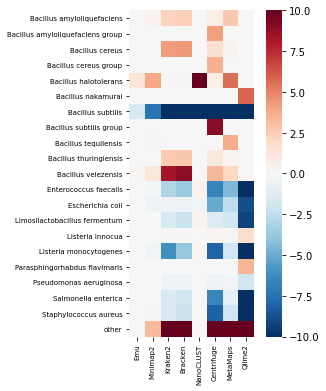

In [6]:
## ZymoBIOMICS Nanopore - species Level

zymo_truth_species = extract_abundance_primary(zymo_nanopore_truth_path, 'species', 'truth')
zymo_emu_species = extract_abundance_emu(zymo_nanopore_emu_path, 'species')
zymo_nanoclust_species = extract_abundance_nanoclust(zymo_nanopore_nanoclust_species_path, 'species')
zymo_centrifuge_species = extract_abundance_centrifuge(zymo_nanopore_centrifuge_path, 'species')
zymo_kraken_species = extract_abundance_kraken(zymo_nanopore_kraken_path, 'species')
zymo_bracken_species = extract_abundance_bracken(zymo_nanopore_bracken_species_path, 'species')
zymo_minimap_species = extract_abundance_primary(zymo_nanopore_minimap_path, 'species', 'Minimap2')
zymo_qiime_species = extract_abundance_qiime(zymo_nanopore_qiime_species_path, 'species')
zymo_metamaps_species = extract_abundance_metamaps(zymo_nanopore_metamaps_path, 'species')


df_results_zymo_nanopore_species = zymo_truth_species
df_results_zymo_nanopore_species = pd.merge(df_results_zymo_nanopore_species, zymo_emu_species, how='outer', on=['species'])
df_results_zymo_nanopore_species = pd.merge(df_results_zymo_nanopore_species, zymo_minimap_species, how='outer', on=['species'])
df_results_zymo_nanopore_species = pd.merge(df_results_zymo_nanopore_species, zymo_kraken_species, how='outer', on=['species'])
df_results_zymo_nanopore_species = pd.merge(df_results_zymo_nanopore_species, zymo_bracken_species, how='outer', on=['species'])
df_results_zymo_nanopore_species = pd.merge(df_results_zymo_nanopore_species, zymo_nanoclust_species, how='outer', on=['species'])
df_results_zymo_nanopore_species = pd.merge(df_results_zymo_nanopore_species, zymo_centrifuge_species, how='outer', on=['species'])
df_results_zymo_nanopore_species = pd.merge(df_results_zymo_nanopore_species, zymo_metamaps_species, how='outer', on=['species'])
df_results_zymo_nanopore_species = pd.merge(df_results_zymo_nanopore_species, zymo_qiime_species, how='outer', on=['species'])
df_results_zymo_nanopore_species = df_results_zymo_nanopore_species.set_index("species")
df_results_zymo_nanopore_species.to_csv("./results_spreadsheets/zymo_nanopore_species.tsv", sep='\t')

#df_results_zymo_nanopore_species_drop_thresh = trim_df_treshold(df_results_zymo_nanopore_species, 2)
#df_results_zymo_nanopore_species_drop_thresh = df_results_zymo_nanopore_species_drop_thresh.sort_index()
#df_results_zymo_nanopore_species_drop_thresh = df_results_zymo_nanopore_species_drop_thresh.reset_index()
#df_results_zymo_nanopore_species_drop_thresh.plot.bar(x='species', title = "ZymoBIOMICS Mock Nanopore Abundances - species Level",ylabel="relative abundance (%)").legend(loc='center left',bbox_to_anchor=(1.0, 0.8)).get_figure()#.savefig("/Users/kcurry/Desktop/EM_results_zymo_mock_species.jpg", bbox_inches='tight')

df_results_zymo_nanopore_species_top20 = trim_df_keep_some(df_results_zymo_nanopore_species, top_num_df(df_results_zymo_nanopore_species))
zymo_nanopore_species_diff = absolute_diff_heatmap(df_results_zymo_nanopore_species_top20, "zymo_nanopore_species")

print_L1_L2(df_results_zymo_nanopore_species, 'truth')
print(".01% THRESHOLD\n")
df_results_zymo_nanopore_species[df_results_zymo_nanopore_species<.01]=0
print_precision_recall(df_results_zymo_nanopore_species, 'truth')

"The microbial standard is accurately characterized and contains negligible impurities (< 0.01%)"


In [7]:
## ZymoBIOMICS Nanopore - species Level compated to theoretical (16S copy number)

zymo_theoretical_species = extract_abundance_theoretical(zymo_theoretical_path, 'species')

df_results_zymo_nanopore_species_theoretical = zymo_theoretical_species
df_results_zymo_nanopore_species_theoretical = pd.merge(df_results_zymo_nanopore_species_theoretical, df_results_zymo_nanopore_species, how='outer', on=['species'])
df_results_zymo_nanopore_species_theoretical = df_results_zymo_nanopore_species_theoretical.set_index("species")
df_results_zymo_nanopore_species_theoretical.to_csv("./results_spreadsheets/zymo_nanopore_species_copy_number_theoretical.tsv", sep='\t')
print_L1_L2(df_results_zymo_nanopore_species_theoretical, 'theoretical')
#print_precision_recall(df_results_zymo_nanopore_species_theoretical, 'truth')


L1:
truth         0.251550
Emu           0.251703
Minimap2      0.317391
Kraken2       0.662400
Bracken       0.657360
NanoCLUST     0.400184
Centrifuge    1.052831
MetaMaps      0.627397
Qiime2        1.135699

L2:
truth         0.112233
Emu           0.107850
Minimap2      0.114846
Kraken2       0.209183
Bracken       0.210771
NanoCLUST     0.166877
Centrifuge    0.250292
MetaMaps      0.188449
Qiime2        0.381337



In [8]:
## Baciullus in Minimap and Emu analysis

df_zymo_minimap_emu = df_results_zymo_nanopore_species[['Emu', 'Minimap2']].dropna(how='all').reset_index()
df_zymo_Bacillus = df_zymo_minimap_emu[df_zymo_minimap_emu['species'].apply(lambda x:"Bacillus" in x)]
df_zymo_Bacillus = df_zymo_Bacillus[df_zymo_Bacillus['Minimap2']!=0]

df_zymo_Bacillus.to_csv("./results_spreadsheets/zymo_bacillus.tsv", sep='\t')



L1:
Emu         0.043583
Minimap2    0.069680
Kraken2     0.394267
Bracken     0.304100
Qiime2      0.306003

L2:
Emu         0.015250
Minimap2    0.020066
Kraken2     0.141172
Bracken     0.105683
Qiime2      0.144415

.01% THRESHOLD



true_positives  false_positives  precision  recall   f_score
truth                  8                0   1.000000   1.000  1.000000
Emu                    8                9   0.470588   1.000  0.640000
Minimap2               8               27   0.228571   1.000  0.372093
Kraken2                8               65   0.109589   1.000  0.197531
Bracken                8               64   0.111111   1.000  0.200000
Qiime2                 7                1   0.875000   0.875  0.875000

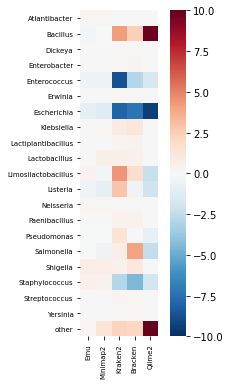

In [9]:
## ZymoBIOMICS Illumina - Genus Level

zymo_illumina_truth_genus = extract_abundance_primary(zymo_illumina_truth_path, 'genus', 'truth')
zymo_illumina_emu_genus = extract_abundance_emu(zymo_illumina_emu_path, 'genus')
zymo_illumina_kraken_genus = extract_abundance_kraken(zymo_illumina_kraken_path, 'genus')
zymo_illumina_bracken_genus = extract_abundance_bracken(zymo_illumina_bracken_genus_path, 'genus')
zymo_illumina_qiime_genus = extract_abundance_qiime(zymo_illumina_qiime_genus_path, 'genus')
zymo_illumina_minimap_genus = extract_abundance_primary(zymo_illumina_minimap_path, 'genus', 'Minimap2')

df_results_zymo_illumina_genus = zymo_illumina_truth_genus
df_results_zymo_illumina_genus = pd.merge(df_results_zymo_illumina_genus, zymo_illumina_emu_genus, how='outer', on=['genus'])
df_results_zymo_illumina_genus = pd.merge(df_results_zymo_illumina_genus, zymo_illumina_minimap_genus, how='outer', on=['genus'])
df_results_zymo_illumina_genus = pd.merge(df_results_zymo_illumina_genus, zymo_illumina_kraken_genus, how='outer', on=['genus'])
df_results_zymo_illumina_genus = pd.merge(df_results_zymo_illumina_genus, zymo_illumina_bracken_genus, how='outer', on=['genus'])
df_results_zymo_illumina_genus = pd.merge(df_results_zymo_illumina_genus, zymo_illumina_qiime_genus, how='outer', on=['genus'])
df_results_zymo_illumina_genus = df_results_zymo_illumina_genus.set_index("genus")
df_results_zymo_illumina_genus.to_csv("./results_spreadsheets/zymo_illumina_genus.tsv", sep='\t')

#df_results_zymo_illumina_genus_drop_thresh = trim_df_treshold(df_results_zymo_illumina_genus, 0.5)
#df_results_zymo_illumina_genus_drop_thresh = df_results_zymo_illumina_genus_drop_thresh.sort_index()
#df_results_zymo_illumina_genus_drop_thresh = df_results_zymo_illumina_genus_drop_thresh.reset_index()
#df_results_zymo_illumina_genus_drop_thresh.plot.bar(x='genus', title = "ZymoBIOMICS Mock illumina Abundances - Genus Level",ylabel="relative abundance (%)").legend(loc='center left',bbox_to_anchor=(1.0, 0.8)).get_figure()#.savefig("/Users/kcurry/Desktop/EM_results_zymo_mock_genus.jpg", bbox_inches='tight')

df_results_zymo_illumina_genus_top20 = trim_df_keep_some(df_results_zymo_illumina_genus, top_num_df(df_results_zymo_illumina_genus))
zymo_illumina_genus_diff = absolute_diff_heatmap(df_results_zymo_illumina_genus_top20, "zymo_illumina_genus")

print_L1_L2(df_results_zymo_illumina_genus, 'truth')
print(".01% THRESHOLD\n")
df_results_zymo_illumina_genus[df_results_zymo_illumina_genus<.01]=0
print_precision_recall(df_results_zymo_illumina_genus, 'truth')


L1:
Emu         0.336216
Minimap2    0.394746
Kraken2     1.176318
Bracken     0.893919
Qiime2      0.933437

L2:
Emu         0.112919
Minimap2    0.116221
Kraken2     0.384734
Bracken     0.230559
Qiime2      0.349443

.01% THRESHOLD



true_positives  false_positives  precision  recall   f_score
truth                  8                0   1.000000   1.000  1.000000
Emu                    8               81   0.089888   1.000  0.164948
Minimap2               8              120   0.062500   1.000  0.117647
Kraken2                8              262   0.029630   1.000  0.057554
Bracken                8              195   0.039409   1.000  0.075829
Qiime2                 1                2   0.333333   0.125  0.181818

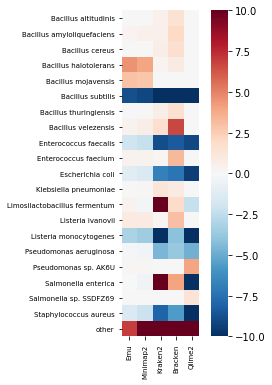

In [10]:
## ZymoBIOMICS Illumina - species Level

zymo_illumina_truth_species = extract_abundance_primary(zymo_illumina_truth_path, 'species', 'truth')
zymo_illumina_emu_species = extract_abundance_emu(zymo_illumina_emu_path, 'species')
zymo_illumina_kraken_species = extract_abundance_kraken(zymo_illumina_kraken_path, 'species')
zymo_illumina_bracken_species = extract_abundance_bracken(zymo_illumina_bracken_species_path, 'species')
zymo_illumina_qiime_species = extract_abundance_qiime(zymo_illumina_qiime_species_path, 'species')
zymo_illumina_minimap_species = extract_abundance_primary(zymo_illumina_minimap_path, 'species', 'Minimap2')

df_results_zymo_illumina_species = zymo_illumina_truth_species
df_results_zymo_illumina_species = pd.merge(df_results_zymo_illumina_species, zymo_illumina_emu_species, how='outer', on=['species'])
df_results_zymo_illumina_species = pd.merge(df_results_zymo_illumina_species, zymo_illumina_minimap_species, how='outer', on=['species'])
df_results_zymo_illumina_species = pd.merge(df_results_zymo_illumina_species, zymo_illumina_kraken_species, how='outer', on=['species'])
df_results_zymo_illumina_species = pd.merge(df_results_zymo_illumina_species, zymo_illumina_bracken_species, how='outer', on=['species'])
df_results_zymo_illumina_species = pd.merge(df_results_zymo_illumina_species, zymo_illumina_qiime_species, how='outer', on=['species'])
df_results_zymo_illumina_species = df_results_zymo_illumina_species.set_index("species")
df_results_zymo_illumina_species.to_csv("./results_spreadsheets/zymo_illumina_species.tsv", sep='\t')

#df_results_zymo_illumina_species_drop_thresh = trim_df_treshold(df_results_zymo_illumina_species, 1)
#df_results_zymo_illumina_species_drop_thresh = df_results_zymo_illumina_species_drop_thresh.sort_index()
#df_results_zymo_illumina_species_drop_thresh = df_results_zymo_illumina_species_drop_thresh.reset_index()
#df_results_zymo_illumina_species_drop_thresh.plot.bar(x='species', title = "ZymoBIOMICS Mock illumina Abundances - species Level",ylabel="relative abundance (%)").legend(loc='center left',bbox_to_anchor=(1.0, 0.8)).get_figure()#.savefig("/Users/kcurry/Desktop/EM_results_zymo_mock_species.jpg", bbox_inches='tight')

df_results_zymo_illumina_species_top20 = trim_df_keep_some(df_results_zymo_illumina_species, top_num_df(df_results_zymo_illumina_species))
zymo_illumina_species_diff = absolute_diff_heatmap(df_results_zymo_illumina_species_top20, "zymo_illumina_species")

print_L1_L2(df_results_zymo_illumina_species, 'truth')
print(".01% THRESHOLD\n")
df_results_zymo_illumina_species[df_results_zymo_illumina_species<.01]=0
print_precision_recall(df_results_zymo_illumina_species, 'truth')

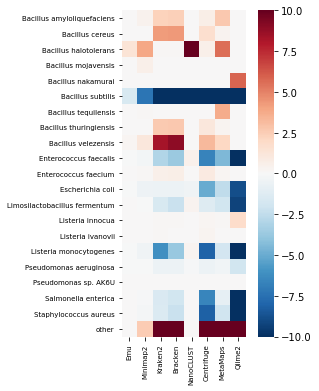

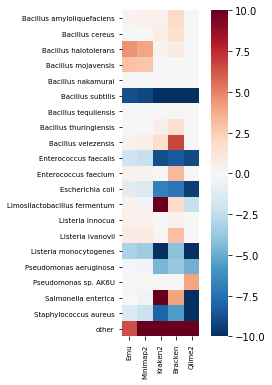

In [11]:
## species-level heatmap for both sequencers with matching rows

zymo_species_top_20 = top_num_both_dfs(df_results_zymo_nanopore_species, df_results_zymo_illumina_species)

df_results_zymo_nanopore_species_top20_match = trim_df_keep_some(df_results_zymo_nanopore_species, zymo_species_top_20)
zymo_nanopore_species_top20_match_diff = absolute_diff_heatmap(df_results_zymo_nanopore_species_top20_match, "zymo_nanopore_species")

df_results_zymo_illumina_species_top20_match = trim_df_keep_some(df_results_zymo_illumina_species, zymo_species_top_20)
zymo_illumina_species_top20_match_diff =absolute_diff_heatmap(df_results_zymo_illumina_species_top20_match, "zymo_illumina_species")



## Synthetic - Tor  


#### Nanopore
#reads: 302,309


#### Illumina (v4)
#reads: 150,903


In [12]:
## Tor results_quantitative - paths

tor_theoretical_path = "./results_quantitative/truth/tor_theoretical.csv"
tor_illumina_truth_path = "./results_quantitative/truth/tor_illumina_restricted_efaecalis_bwa_primary.tsv"
tor_nanopore_truth_path = "./results_quantitative/truth/tor_nanopore_restricted_efaecalis_minimap_primary.tsv"

tor_nanopore_emu_path = "./results_quantitative/Emu_v3/tor_nanopore_rel-abundance.tsv"
tor_nanopore_nanoclust_species_path = "./results_quantitative/nanoclust/rel_abundance_tor_nanopore_guppy_S.csv"
tor_nanopore_nanoclust_genus_path = "./results_quantitative/nanoclust/rel_abundance_tor_nanopore_guppy_G.csv"
tor_nanopore_centrifuge_path = "./results_quantitative/Centrifuge/tor_nanopore.classification.kreport.tsv"
tor_nanopore_kraken_path = "./results_quantitative/Kraken2/tor_nanopore.kreport"
tor_nanopore_bracken_species_path = "./results_quantitative/Bracken/tor_nanopore_bracken_species.tsv"
tor_nanopore_bracken_genus_path = "./results_quantitative/Bracken/tor_nanopore_bracken_genus.tsv"
tor_nanopore_minimap_path = "./results_quantitative/Minimap2/tor_nanopore_minimap2.tsv"
tor_nanopore_qiime_genus_path = "./results_quantitative/Qiime2/tor_nanopore_derep-rel-genus-table.tsv"
tor_nanopore_qiime_species_path = "./results_quantitative/Qiime2/tor_nanopore_derep-rel-species-table.tsv"
tor_nanopore_metamaps_path = "./results_quantitative/MetaMaps/tor_nanopore_guppy.EM.WIMP"

tor_illumina_emu_path = "./results_quantitative/Emu_v3/tor_illumina_rel-abundance.tsv"
tor_illumina_qiime_genus_path = "./results_quantitative/Qiime2/tor_illumina-rel-genus-table.tsv"
tor_illumina_qiime_species_path = "./results_quantitative/Qiime2/tor_illumina-rel-species-table.tsv"
tor_illumina_kraken_path = "./results_quantitative/kraken2/tor_illumina.kreport"
tor_illumina_bracken_species_path = "./results_quantitative/bracken/tor_illumina_bracken_species.tsv"
tor_illumina_bracken_genus_path = "./results_quantitative/bracken/tor_illumina_bracken_genus.tsv"
tor_illumina_minimap_path = "./results_quantitative/Minimap2/tor_illumina_minimap2.tsv"


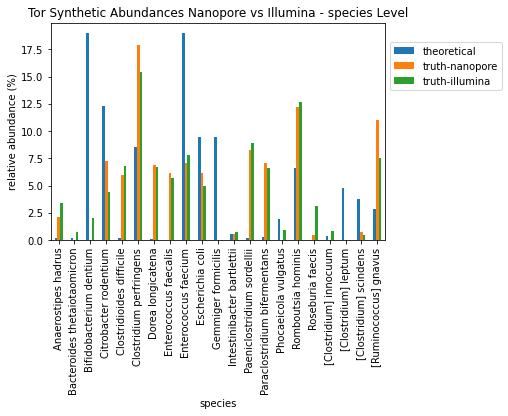

In [13]:
## Compare Illumina to Nanopore Expected - Tor Synthetic - species

tor_theoretical_species = extract_abundance_theoretical(tor_theoretical_path, 'species')
tor_nanopore_truth_species = extract_abundance_primary(tor_nanopore_truth_path, 'species', 'truth-nanopore')
tor_illumina_truth_species = extract_abundance_primary(tor_illumina_truth_path, 'species', 'truth-illumina')

df_results_tor_species = tor_theoretical_species
df_results_tor_species = pd.merge(df_results_tor_species, tor_nanopore_truth_species, how='outer', on=['species'])
df_results_tor_species = pd.merge(df_results_tor_species, tor_illumina_truth_species, how='outer', on=['species'])

df_results_tor_species = df_results_tor_species.sort_values('species')
df_results_tor_species.plot.bar(x='species', title = "Tor Synthetic Abundances Nanopore vs Illumina - species Level",ylabel="relative abundance (%)").legend(loc='center left',bbox_to_anchor=(1.0, 0.8)).get_figure()#.savefig("/Users/kcurry/Desktop/EM_results_tor_mock_species.jpg", bbox_inches='tight')

plt.show()

L1:
Emu           0.031314
Minimap2      0.046835
Kraken2       0.414476
Bracken       0.793576
NanoCLUST     0.338018
Centrifuge    0.303137
MetaMaps      0.534047
Qiime2        0.669780

L2:
Emu           0.012777
Minimap2      0.017513
Kraken2       0.137953
Bracken       0.245927
NanoCLUST     0.151102
Centrifuge    0.076673
MetaMaps      0.157765
Qiime2        0.197779



true_positives  false_positives  precision    recall   f_score
truth                   18                0   1.000000  1.000000  1.000000
Emu                     18               15   0.545455  1.000000  0.705882
Minimap2                18               93   0.162162  1.000000  0.279070
Kraken2                 18              505   0.034417  1.000000  0.066543
Bracken                 14               80   0.148936  0.777778  0.250000
NanoCLUST               14                2   0.875000  0.777778  0.823529
Centrifuge              18             1007   0.017561  1.000000  0.034516
MetaMaps                17              381   0.042714  0.944444  0.081731
Qiime2                  14               31   0.311111  0.777778  0.444444

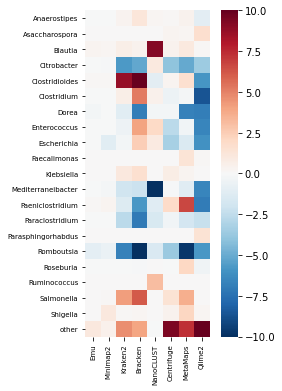

In [14]:
## Tor Nanopore - Genus Level

tor_nanopore_truth_genus = extract_abundance_primary(tor_nanopore_truth_path, 'genus', 'truth')
tor_nanopore_emu_genus = extract_abundance_emu(tor_nanopore_emu_path, 'genus')
tor_nanopore_nanoclust_genus = extract_abundance_nanoclust(tor_nanopore_nanoclust_genus_path, 'genus')
tor_nanopore_centrifuge_genus = extract_abundance_centrifuge(tor_nanopore_centrifuge_path, 'genus')
tor_nanopore_kraken_genus = extract_abundance_kraken(tor_nanopore_kraken_path, 'genus')
tor_nanopore_bracken_genus = extract_abundance_bracken(tor_nanopore_bracken_genus_path, 'genus')
tor_nanopore_minimap_genus = extract_abundance_primary(tor_nanopore_minimap_path, 'genus', 'Minimap2')
tor_nanopore_qiime_genus = extract_abundance_qiime(tor_nanopore_qiime_genus_path, 'genus')
tor_nanopore_metamaps_genus = extract_abundance_metamaps(tor_nanopore_metamaps_path, 'genus')

df_results_tor_nanopore_genus = tor_nanopore_truth_genus
df_results_tor_nanopore_genus = pd.merge(df_results_tor_nanopore_genus, tor_nanopore_emu_genus, how='outer', on=['genus'])
df_results_tor_nanopore_genus = pd.merge(df_results_tor_nanopore_genus, tor_nanopore_minimap_genus, how='outer', on=['genus'])
df_results_tor_nanopore_genus = pd.merge(df_results_tor_nanopore_genus, tor_nanopore_kraken_genus, how='outer', on=['genus'])
df_results_tor_nanopore_genus = pd.merge(df_results_tor_nanopore_genus, tor_nanopore_bracken_genus, how='outer', on=['genus'])
df_results_tor_nanopore_genus = pd.merge(df_results_tor_nanopore_genus, tor_nanopore_nanoclust_genus, how='outer', on=['genus'])
df_results_tor_nanopore_genus = pd.merge(df_results_tor_nanopore_genus, tor_nanopore_centrifuge_genus, how='outer', on=['genus'])
df_results_tor_nanopore_genus = pd.merge(df_results_tor_nanopore_genus, tor_nanopore_metamaps_genus, how='outer', on=['genus'])
df_results_tor_nanopore_genus = pd.merge(df_results_tor_nanopore_genus, tor_nanopore_qiime_genus, how='outer', on=['genus'])
df_results_tor_nanopore_genus = df_results_tor_nanopore_genus.set_index("genus")
df_results_tor_nanopore_genus.to_csv("./results_spreadsheets/tor_nanopore_genus.tsv", sep='\t')

#df_results_tor_nanopore_genus_drop_thresh = trim_df_treshold(df_results_tor_nanopore_genus, 1)
#df_results_tor_nanopore_genus_drop_thresh = trim_df_col(df_results_tor_nanopore_genus, 'truth')
#df_results_tor_nanopore_genus_drop_thresh = df_results_tor_nanopore_genus_drop_thresh.sort_index()
#df_results_tor_nanopore_genus_drop_thresh = df_results_tor_nanopore_genus_drop_thresh.reset_index()
#df_results_tor_nanopore_genus_drop_thresh.plot.bar(x='genus', title = "Tor Synthetic Nanopore Abundances - Genus Level",ylabel="relative abundance (%)").legend(loc='center left',bbox_to_anchor=(1.0, 0.8)).get_figure()#.savefig("/Users/kcurry/Desktop/EM_results_tor_mock_genus.jpg", bbox_inches='tight')

df_results_tor_nanopore_genus_top20 = trim_df_keep_some(df_results_tor_nanopore_genus, top_num_df(df_results_tor_nanopore_genus))
tor_nanopore_genus_diff = absolute_diff_heatmap(df_results_tor_nanopore_genus_top20, "tor_nanopore_genus")

print_L1_L2(df_results_tor_nanopore_genus, 'truth')
print_precision_recall(df_results_tor_nanopore_genus, 'truth')


In [15]:
## Tor Nanopore - species Level

tor_nanopore_truth_species = extract_abundance_primary(tor_nanopore_truth_path, 'species', 'truth')
tor_nanopore_emu_species = extract_abundance_emu(tor_nanopore_emu_path, 'species')
tor_nanopore_nanoclust_species = extract_abundance_nanoclust(tor_nanopore_nanoclust_species_path, 'species')
tor_nanopore_centrifuge_species = extract_abundance_centrifuge(tor_nanopore_centrifuge_path, 'species')
tor_nanopore_kraken_species = extract_abundance_kraken(tor_nanopore_kraken_path, 'species')
tor_nanopore_bracken_species = extract_abundance_bracken(tor_nanopore_bracken_species_path, 'species')
tor_nanopore_minimap_species = extract_abundance_primary(tor_nanopore_minimap_path, 'species', 'Minimap2')
tor_nanopore_qiime_species = extract_abundance_qiime(tor_nanopore_qiime_species_path, 'species')
tor_nanopore_metamaps_species = extract_abundance_metamaps(tor_nanopore_metamaps_path, 'species')

df_results_tor_nanopore_species = tor_nanopore_truth_species
df_results_tor_nanopore_species = pd.merge(df_results_tor_nanopore_species, tor_nanopore_emu_species, how='outer', on=['species'])
df_results_tor_nanopore_species = pd.merge(df_results_tor_nanopore_species, tor_nanopore_minimap_species, how='outer', on=['species'])
df_results_tor_nanopore_species = pd.merge(df_results_tor_nanopore_species, tor_nanopore_kraken_species, how='outer', on=['species'])
df_results_tor_nanopore_species = pd.merge(df_results_tor_nanopore_species, tor_nanopore_bracken_species, how='outer', on=['species'])
df_results_tor_nanopore_species = pd.merge(df_results_tor_nanopore_species, tor_nanopore_nanoclust_species, how='outer', on=['species'])
df_results_tor_nanopore_species = pd.merge(df_results_tor_nanopore_species, tor_nanopore_centrifuge_species, how='outer', on=['species'])
df_results_tor_nanopore_species = pd.merge(df_results_tor_nanopore_species, tor_nanopore_metamaps_species, how='outer', on=['species'])
df_results_tor_nanopore_species = pd.merge(df_results_tor_nanopore_species, tor_nanopore_qiime_species, how='outer', on=['species'])
df_results_tor_nanopore_species = df_results_tor_nanopore_species.set_index("species")
df_results_tor_nanopore_species.to_csv("./results_spreadsheets/tor_nanopore_species.tsv", sep='\t')

#df_results_tor_nanopore_species_drop_thresh = trim_df_treshold(df_results_tor_nanopore_species, 2)
#df_results_tor_nanopore_species_drop_thresh = trim_df_col(df_results_tor_nanopore_species, 'truth')
#df_results_tor_nanopore_species_drop_thresh = df_results_tor_nanopore_species_drop_thresh.sort_index()
#df_results_tor_nanopore_species_drop_thresh = df_results_tor_nanopore_species_drop_thresh.reset_index()
#df_results_tor_nanopore_species_drop_thresh.plot.bar(x='species', title = "Tor Synthetic Nanopore Abundances - species Level",ylabel="relative abundance (%)").legend(loc='center left',bbox_to_anchor=(1.0, 0.8)).get_figure()#.savefig("/Users/kcurry/Desktop/EM_results_tor_mock_species.jpg", bbox_inches='tight')

df_results_tor_nanopore_species_top20 = trim_df_keep_some(df_results_tor_nanopore_species, top_num_df(df_results_tor_nanopore_species))
tor_nanopore_species_diff = absolute_diff_heatmap(df_results_tor_nanopore_species_top20, "tor_nanopore_species")

print_L1_L2(df_results_tor_nanopore_species, 'truth')
print_precision_recall(df_results_tor_nanopore_species, 'truth')

thresh = 10/295882*100
print(f"{thresh} THRESHOLD\n")
df_results_tor_nanopore_species_copy = df_results_tor_nanopore_species.copy()
df_results_tor_nanopore_species_copy[df_results_tor_nanopore_species_copy<=thresh]=0
#df_results_tor_nanopore_species_copy['truth'] = df_results_tor_nanopore_species['truth']
print_precision_recall(df_results_tor_nanopore_species_copy, 'truth')
print_L1_L2(df_results_tor_nanopore_species_copy, 'truth')

## L1/L2 without Romboutsia
df_results_tor_nanopore_species_drop_romb = df_results_tor_nanopore_species.reset_index()
df_results_tor_nanopore_species_drop_romb['species'] = df_results_tor_nanopore_species_drop_romb['species'].apply(lambda x: x.split(" ")[0])
df_results_tor_nanopore_species_drop_romb = df_results_tor_nanopore_species_drop_romb[df_results_tor_nanopore_species_drop_romb['species']!='Romboutsia']
df_results_tor_nanopore_species_drop_romb = df_results_tor_nanopore_species_drop_romb.set_index("species")

print("L1/L2 without Romboutsia")
print_L1_L2(df_results_tor_nanopore_species_drop_romb, 'truth')


L1:
Emu           0.433352
Minimap2      0.437643
Kraken2       0.757996
Bracken       0.832160
NanoCLUST     0.499742
Centrifuge    0.664676
MetaMaps      0.743816
Qiime2        1.168040

L2:
Emu           0.188775
Minimap2      0.181556
Kraken2       0.203296
Bracken       0.244501
NanoCLUST     0.190683
Centrifuge    0.163823
MetaMaps      0.178771
Qiime2        0.309525



true_positives  false_positives  precision  recall   f_score
truth                   20                0   1.000000    1.00  1.000000
Emu                     18               40   0.310345    0.90  0.461538
Minimap2                19              252   0.070111    0.95  0.130584
Kraken2                 19             1156   0.016170    0.95  0.031799
Bracken                 12              166   0.067416    0.60  0.121212
NanoCLUST               14                4   0.777778    0.70  0.736842
Centrifuge              19             2372   0.007946    0.95  0.015761
MetaMaps                17              836   0.019930    0.85  0.038946
Qiime2                   9               55   0.140625    0.45  0.214286



0.0033797257014620695 THRESHOLD



true_positives  false_positives  precision    recall   f_score
truth                   19                0   1.000000  1.000000  1.000000
Emu                     18               40   0.310345  0.947368  0.467532
Minimap2                17               52   0.246377  0.894737  0.386364
Kraken2                 17              291   0.055195  0.894737  0.103976
Bracken                 12              165   0.067797  0.631579  0.122449
NanoCLUST               14                4   0.777778  0.736842  0.756757
Centrifuge              18              507   0.034286  0.947368  0.066176
MetaMaps                17              231   0.068548  0.894737  0.127341
Qiime2                   7               28   0.200000  0.368421  0.259259



L1:
Emu           0.433335
Minimap2      0.436162
Kraken2       0.750388
Bracken       0.832133
NanoCLUST     0.499725
Centrifuge    0.646874
MetaMaps      0.738496
Qiime2        1.167813

L2:
Emu           0.188775
Minimap2      0.181556
Kraken2       0.203295
Bracken       0.244501
NanoCLUST     0.190683
Centrifuge    0.163822
MetaMaps      0.178771
Qiime2        0.309525

L1/L2 without Romboutsia
L1:
Emu           0.200133
Minimap2      0.204661
Kraken2       0.583516
Bracken       0.710399
NanoCLUST     0.271721
Centrifuge    0.474788
MetaMaps      0.605304
Qiime2        1.014949

L2:
Emu           0.092447
Minimap2      0.083686
Kraken2       0.159941
Bracken       0.212026
NanoCLUST     0.101207
Centrifuge    0.100294
MetaMaps      0.130049
Qiime2        0.282839



## Tor Illumina results


L1:
Emu         0.339372
Minimap2    0.353167
Kraken2     0.897359
Bracken     0.771382
Qiime2      0.447911

L2:
Emu         0.182667
Minimap2    0.161294
Kraken2     0.292922
Bracken     0.270112
Qiime2      0.170729



true_positives  false_positives  precision    recall   f_score
truth                 19                0   1.000000  1.000000  1.000000
Emu                   17               14   0.548387  0.894737  0.680000
Minimap2              18              557   0.031304  0.947368  0.060606
Kraken2               17              291   0.055195  0.894737  0.103976
Bracken               16               59   0.213333  0.842105  0.340426
Qiime2                14                3   0.823529  0.736842  0.777778

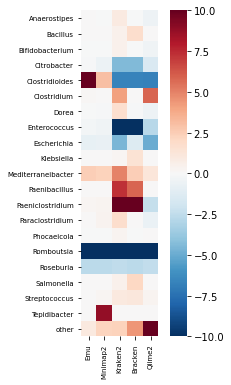

In [16]:
## Tor illumina - Genus Level

tor_illumina_truth_genus = extract_abundance_primary(tor_illumina_truth_path, 'genus', 'truth')
tor_illumina_emu_genus = extract_abundance_emu(tor_illumina_emu_path, 'genus')
tor_illumina_kraken_genus = extract_abundance_kraken(tor_illumina_kraken_path, 'genus')
tor_illumina_bracken_genus = extract_abundance_bracken(tor_illumina_bracken_genus_path, 'genus')
tor_illumina_qiime_genus = extract_abundance_qiime(tor_illumina_qiime_genus_path, 'genus')
tor_illumina_minimap_genus = extract_abundance_primary(tor_illumina_minimap_path, 'genus', 'Minimap2')

df_results_tor_illumina_genus = tor_illumina_truth_genus
df_results_tor_illumina_genus = pd.merge(df_results_tor_illumina_genus, tor_illumina_emu_genus, how='outer', on=['genus'])
df_results_tor_illumina_genus = pd.merge(df_results_tor_illumina_genus, tor_illumina_minimap_genus, how='outer', on=['genus'])
df_results_tor_illumina_genus = pd.merge(df_results_tor_illumina_genus, tor_illumina_kraken_genus, how='outer', on=['genus'])
df_results_tor_illumina_genus = pd.merge(df_results_tor_illumina_genus, tor_illumina_bracken_genus, how='outer', on=['genus'])
df_results_tor_illumina_genus = pd.merge(df_results_tor_illumina_genus, tor_illumina_qiime_genus, how='outer', on=['genus'])
df_results_tor_illumina_genus = df_results_tor_illumina_genus.set_index("genus")
df_results_tor_illumina_genus.to_csv("./results_spreadsheets/tor_illumina_genus.tsv", sep='\t')

#df_results_tor_illumina_genus_drop_thresh = trim_df_treshold(df_results_tor_illumina_genus, 2)
#df_results_tor_illumina_genus_drop_thresh = trim_df_col(df_results_tor_illumina_genus, 'truth')
#df_results_tor_illumina_genus_drop_thresh = df_results_tor_illumina_genus_drop_thresh.sort_index()
#df_results_tor_illumina_genus_drop_thresh = df_results_tor_illumina_genus_drop_thresh.reset_index()
#df_results_tor_illumina_genus_drop_thresh.plot.bar(x='genus', title = "Tor Synthetic Abundances Illumina - Genus Level",ylabel="relative abundance (%)").legend(loc='center left',bbox_to_anchor=(1.0, 0.8)).get_figure()#.savefig("/Users/kcurry/Desktop/EM_results_tor_mock_genus.jpg", bbox_inches='tight')

df_results_tor_illumina_genus_top20 = trim_df_keep_some(df_results_tor_illumina_genus, top_num_df(df_results_tor_illumina_genus))
tor_illumina_genus_diff = absolute_diff_heatmap(df_results_tor_illumina_genus_top20, "tor_illumina_genus")

print_L1_L2(df_results_tor_illumina_genus, 'truth')
print_precision_recall(df_results_tor_illumina_genus, 'truth')


In [17]:
## Tor illumina - species Level

tor_illumina_truth_species = extract_abundance_primary(tor_illumina_truth_path, 'species', 'truth')
tor_illumina_emu_species = extract_abundance_emu(tor_illumina_emu_path, 'species')
tor_illumina_kraken_species = extract_abundance_kraken(tor_illumina_kraken_path, 'species')
tor_illumina_bracken_species = extract_abundance_bracken(tor_illumina_bracken_species_path, 'species')
tor_illumina_qiime_species = extract_abundance_qiime(tor_illumina_qiime_species_path,'species')
tor_illumina_minimap_species = extract_abundance_primary(tor_illumina_minimap_path, 'species', 'Minimap2')

df_results_tor_illumina_species = tor_illumina_truth_species
df_results_tor_illumina_species = pd.merge(df_results_tor_illumina_species, tor_illumina_emu_species, how='outer', on=['species'])
df_results_tor_illumina_species = pd.merge(df_results_tor_illumina_species, tor_illumina_minimap_species, how='outer', on=['species'])
df_results_tor_illumina_species = pd.merge(df_results_tor_illumina_species, tor_illumina_kraken_species, how='outer', on=['species'])
df_results_tor_illumina_species = pd.merge(df_results_tor_illumina_species, tor_illumina_bracken_species, how='outer', on=['species'])
df_results_tor_illumina_species = pd.merge(df_results_tor_illumina_species, tor_illumina_qiime_species, how='outer', on=['species'])
df_results_tor_illumina_species = df_results_tor_illumina_species.set_index("species")
df_results_tor_illumina_species.to_csv("./results_spreadsheets/tor_illumina_species.tsv", sep='\t')

#df_results_tor_illumina_species_drop_thresh = trim_df_treshold(df_results_tor_illumina_species, 2)
#df_results_tor_illumina_species_drop_thresh = trim_df_col(df_results_tor_illumina_species, 'truth')
#df_results_tor_illumina_species_drop_thresh = df_results_tor_illumina_species_drop_thresh.sort_index()
#df_results_tor_illumina_species_drop_thresh = df_results_tor_illumina_species_drop_thresh.reset_index()
#df_results_tor_illumina_species_drop_thresh.plot.bar(x='species', title = "Tor Synthetic Abundances Illumina - species Level",ylabel="relative abundance (%)").legend(loc='center left',bbox_to_anchor=(1.0, 0.8)).get_figure()#.savefig("/Users/kcurry/Desktop/EM_results_tor_mock_species.jpg", bbox_inches='tight')

df_results_tor_illumina_species_top20 = trim_df_keep_some(df_results_tor_illumina_species, top_num_df(df_results_tor_illumina_species))
tor_illumina_species_diff = absolute_diff_heatmap(df_results_tor_illumina_species_top20, "tor_illumina_species")

print_L1_L2(df_results_tor_illumina_species, 'truth')
print_precision_recall(df_results_tor_illumina_species, 'truth')

## L1/L2 without Romboutsia
df_results_tor_illumina_species_drop_romb = df_results_tor_illumina_species.reset_index()
df_results_tor_illumina_species_drop_romb['species'] = df_results_tor_illumina_species_drop_romb['species'].apply(lambda x: x.split(" ")[0])
df_results_tor_illumina_species_drop_romb = df_results_tor_illumina_species_drop_romb[df_results_tor_illumina_species_drop_romb['species']!='Romboutsia']
df_results_tor_illumina_species_drop_romb = df_results_tor_illumina_species_drop_romb.set_index("species")

print("L1/L2 without Romboutsia")
print_L1_L2(df_results_tor_illumina_species_drop_romb, 'truth')

L1:
Emu         0.507347
Minimap2    0.538672
Kraken2     1.264436
Bracken     1.203297
Qiime2      1.133353

L2:
Emu         0.190128
Minimap2    0.170615
Kraken2     0.331371
Bracken     0.372195
Qiime2      0.349186



true_positives  false_positives  precision    recall   f_score
truth                 21                0   1.000000  1.000000  1.000000
Emu                   16               71   0.183908  0.761905  0.296296
Minimap2              18             1230   0.014423  0.857143  0.028369
Kraken2               15              539   0.027076  0.714286  0.052174
Bracken               12              110   0.098361  0.571429  0.167832
Qiime2                 6                4   0.600000  0.285714  0.387097



L1/L2 without Romboutsia
L1:
Emu         0.380120
Minimap2    0.410816
Kraken2     1.134487
Bracken     1.073107
Qiime2      1.006343

L2:
Emu         0.141482
Minimap2    0.113920
Kraken2     0.306056
Bracken     0.349846
Qiime2      0.325268



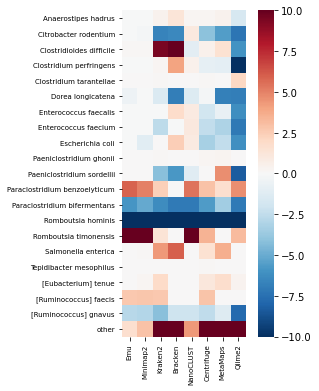

In [18]:
## species-level heatmap for both sequencers with matching rows

tor_species_top_20 = top_num_both_dfs(df_results_tor_nanopore_species, df_results_tor_illumina_species)

df_results_tor_nanopore_species_top20_match = trim_df_keep_some(df_results_tor_nanopore_species, tor_species_top_20)
tor_nanopore_species_top20_match_diff = absolute_diff_heatmap(df_results_tor_nanopore_species_top20_match, "tor_nanopore_species")

df_results_tor_illumina_species_top20_match = trim_df_keep_some(df_results_tor_illumina_species, tor_species_top_20)
tor_illumina_species_top20_match_diff =absolute_diff_heatmap(df_results_tor_illumina_species_top20_match, "tor_illumina_species")


## Simulated MBARC

unique species: 26
number of reads: 958,655

deep_simulator.sh -i reference -n read_number -B 2 -c 20 -o output_filename"

In [19]:
## MBARC results_quantitative - paths

# Nanopore truth - primary assignment to restricted db [minimap2]
mbarc_ncbi_truth_path = "./results_quantitative/truth/mbarc_ncbi_ref_minimap_truth.tsv"
mbarc_ncbi_theoretical_path = "./results_quantitative/truth/mbarc_ncbi_theoretical.csv"

mbarc_ncbi_emu_path = "./results_quantitative/Emu_v3/mbarc_ncbi_rel-abundance.tsv"
mbarc_ncbi_nanoclust_species_path = "./results_quantitative/nanoclust/rel_abundance_mbarc_ncbi_S.csv"
mbarc_ncbi_nanoclust_genus_path = "./results_quantitative/nanoclust/rel_abundance_mbarc_ncbi_G.csv"
mbarc_ncbi_centrifuge_path = "./results_quantitative/Centrifuge/mbarc_ncbi.classification.kreport.tsv"
mbarc_ncbi_kraken_path = "./results_quantitative/Kraken2/mbarc_ncbi.kreport"
mbarc_ncbi_bracken_species_path = "./results_quantitative/Bracken/mbarc_ncbi_bracken_species.tsv"
mbarc_ncbi_bracken_genus_path = "./results_quantitative/Bracken/mbarc_ncbi_bracken_genus.tsv"
mbarc_ncbi_minimap_path = "./results_quantitative/Minimap2/mbarc_ncbi_minimap2.tsv"
mbarc_ncbi_qiime_species_path = "./results_quantitative/Qiime2/mbarc_ncbi_derep-rel-species-table.tsv"
mbarc_ncbi_qiime_genus_path = "./results_quantitative/Qiime2/mbarc_ncbi_derep-rel-genus-table.tsv"
mbarc_ncbi_metamaps_path = "./results_quantitative/MetaMaps/mbarc_ncbi.EM.WIMP"


L1:
Emu           0.000016
Minimap2      0.000318
Kraken2       0.033500
Bracken       0.715069
NanoCLUST     1.768056
Centrifuge    0.013943
MetaMaps      0.422945
Qiime2        0.158531

L2:
Emu           0.000005
Minimap2      0.000159
Kraken2       0.014916
Bracken       0.211106
NanoCLUST     0.785523
Centrifuge    0.003640
MetaMaps      0.113204
Qiime2        0.088303



true_positives  false_positives  precision    recall   f_score
theoretical              24                0   1.000000  1.000000  1.000000
Emu                      24                0   1.000000  1.000000  1.000000
Minimap2                 24               18   0.571429  1.000000  0.727273
Kraken2                  24              339   0.066116  1.000000  0.124031
Bracken                  19               15   0.558824  0.791667  0.655172
NanoCLUST                 4                0   1.000000  0.166667  0.285714
Centrifuge               24              484   0.047244  1.000000  0.090226
MetaMaps                 24              229   0.094862  1.000000  0.173285
Qiime2                   22                8   0.733333  0.916667  0.814815

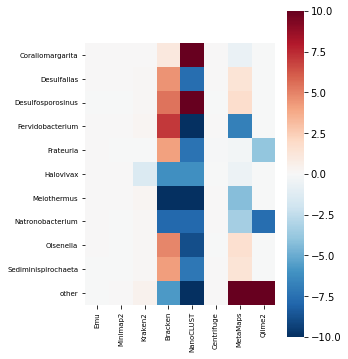

In [20]:
## MBARC Nanopore - Genus Level

mbarc_ncbi_theoretical_genus = extract_abundance_theoretical(mbarc_ncbi_theoretical_path, 'genus')
mbarc_emu_genus = extract_abundance_emu(mbarc_ncbi_emu_path,'genus')
mbarc_nanoclust_genus = extract_abundance_nanoclust(mbarc_ncbi_nanoclust_genus_path, 'genus')
mbarc_centrifuge_genus = extract_abundance_centrifuge(mbarc_ncbi_centrifuge_path, 'genus')
mbarc_kraken_genus = extract_abundance_kraken(mbarc_ncbi_kraken_path, 'genus')
mbarc_bracken_genus = extract_abundance_bracken(mbarc_ncbi_bracken_genus_path, 'genus')
mbarc_minimap_genus = extract_abundance_primary(mbarc_ncbi_minimap_path, 'genus', 'Minimap2')
mbarc_qiime_genus = extract_abundance_qiime(mbarc_ncbi_qiime_genus_path, 'genus')
mbarc_metamaps_genus = extract_abundance_metamaps(mbarc_ncbi_metamaps_path, 'genus')

df_results_mbarc_nanopore_genus = mbarc_ncbi_theoretical_genus
df_results_mbarc_nanopore_genus = pd.merge(df_results_mbarc_nanopore_genus, mbarc_emu_genus, how='outer', on=['genus'])
df_results_mbarc_nanopore_genus = pd.merge(df_results_mbarc_nanopore_genus, mbarc_minimap_genus, how='outer', on=['genus'])
df_results_mbarc_nanopore_genus = pd.merge(df_results_mbarc_nanopore_genus, mbarc_kraken_genus, how='outer', on=['genus'])
df_results_mbarc_nanopore_genus = pd.merge(df_results_mbarc_nanopore_genus, mbarc_bracken_genus, how='outer', on=['genus'])
df_results_mbarc_nanopore_genus = pd.merge(df_results_mbarc_nanopore_genus, mbarc_nanoclust_genus, how='outer', on=['genus'])
df_results_mbarc_nanopore_genus = pd.merge(df_results_mbarc_nanopore_genus, mbarc_centrifuge_genus, how='outer', on=['genus'])
df_results_mbarc_nanopore_genus = pd.merge(df_results_mbarc_nanopore_genus, mbarc_metamaps_genus, how='outer', on=['genus'])
df_results_mbarc_nanopore_genus = pd.merge(df_results_mbarc_nanopore_genus, mbarc_qiime_genus, how='outer', on=['genus'])
df_results_mbarc_nanopore_genus = df_results_mbarc_nanopore_genus.set_index("genus")
df_results_mbarc_nanopore_genus.to_csv("./results_spreadsheets/mbarc_genus.tsv", sep='\t')

#df_results_mbarc_nanopore_genus_drop_thresh = trim_df_treshold(df_results_mbarc_nanopore_genus, 1)
#df_results_mbarc_nanopore_genus_drop_thresh = df_results_mbarc_nanopore_genus_drop_thresh.sort_index()
#df_results_mbarc_nanopore_genus_drop_thresh = df_results_mbarc_nanopore_genus_drop_thresh.reset_index()
#df_results_mbarc_nanopore_genus_drop_thresh.plot.bar(x='genus', title = "MBARC Simulated Nanopore Abundances - Genus Level",ylabel="relative abundance (%)").legend(loc='center left',bbox_to_anchor=(1.0, 0.8)).get_figure()#.savefig("/Users/kcurry/Desktop/EM_results_mbarc_mock_genus.jpg", bbox_inches='tight')

df_results_mbarc_genus_top20 = trim_df_keep_some(df_results_mbarc_nanopore_genus, top_num_df(df_results_mbarc_nanopore_genus, NUM_KEPT=10))
mbarc_genus_diff = absolute_diff_heatmap(df_results_mbarc_genus_top20, "mbarc_genus")

print_L1_L2(df_results_mbarc_nanopore_genus, 'theoretical')
print_precision_recall(df_results_mbarc_nanopore_genus, 'theoretical')

L1:
Emu           0.000033
Minimap2      0.013126
Kraken2       0.141987
Bracken       0.795034
NanoCLUST     1.768056
Centrifuge    0.113754
MetaMaps      0.511050
Qiime2        0.964039

L2:
Emu           0.000013
Minimap2      0.006799
Kraken2       0.050762
Bracken       0.212417
NanoCLUST     0.646778
Centrifuge    0.044833
MetaMaps      0.121627
Qiime2        0.269447



true_positives  false_positives  precision    recall   f_score
theoretical              26                0   1.000000  1.000000  1.000000
Emu                      26                0   1.000000  1.000000  1.000000
Minimap2                 26               73   0.262626  1.000000  0.416000
Kraken2                  25              626   0.038402  0.961538  0.073855
Bracken                  19               43   0.306452  0.730769  0.431818
NanoCLUST                 5                0   1.000000  0.192308  0.322581
Centrifuge               26              860   0.029345  1.000000  0.057018
MetaMaps                 26              415   0.058957  1.000000  0.111349
Qiime2                   16               28   0.363636  0.615385  0.457143



0.0010431281326441734 THRESHOLD



true_positives  false_positives  precision    recall   f_score
theoretical              26                0   1.000000  1.000000  1.000000
Emu                      26                0   1.000000  1.000000  1.000000
Minimap2                 26               12   0.684211  1.000000  0.812500
Kraken2                  24               96   0.200000  0.923077  0.328767
Bracken                  19               43   0.306452  0.730769  0.431818
NanoCLUST                 5                0   1.000000  0.192308  0.322581
Centrifuge               24               80   0.230769  0.923077  0.369231
MetaMaps                 25               84   0.229358  0.961538  0.370370
Qiime2                   14               14   0.500000  0.538462  0.518519



L1:
Emu           0.000033
Minimap2      0.012987
Kraken2       0.140707
Bracken       0.795034
NanoCLUST     1.768056
Centrifuge    0.112040
MetaMaps      0.509998
Qiime2        0.964000

L2:
Emu           0.000013
Minimap2      0.006799
Kraken2       0.050762
Bracken       0.212417
NanoCLUST     0.646778
Centrifuge    0.044833
MetaMaps      0.121627
Qiime2        0.269449



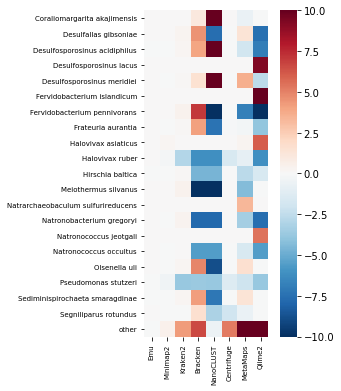

In [21]:
## MBARC Nanopore - species Level

mbarc_ncbi_theoretical_species = extract_abundance_theoretical(mbarc_ncbi_theoretical_path, 'species')
mbarc_emu_species = extract_abundance_emu(mbarc_ncbi_emu_path,'species')
mbarc_nanoclust_species = extract_abundance_nanoclust(mbarc_ncbi_nanoclust_species_path, 'species')
mbarc_centrifuge_species = extract_abundance_centrifuge(mbarc_ncbi_centrifuge_path, 'species')
mbarc_kraken_species = extract_abundance_kraken(mbarc_ncbi_kraken_path, 'species')
mbarc_bracken_species = extract_abundance_bracken(mbarc_ncbi_bracken_species_path, 'species')
mbarc_minimap_species = extract_abundance_primary(mbarc_ncbi_minimap_path, 'species', 'Minimap2')
mbarc_qiime_species = extract_abundance_qiime(mbarc_ncbi_qiime_species_path, 'species')
mbarc_metamaps_species = extract_abundance_metamaps(mbarc_ncbi_metamaps_path, 'species')

df_results_mbarc_nanopore_species = mbarc_ncbi_theoretical_species
df_results_mbarc_nanopore_species = pd.merge(df_results_mbarc_nanopore_species, mbarc_emu_species, how='outer', on=['species'])
df_results_mbarc_nanopore_species = pd.merge(df_results_mbarc_nanopore_species, mbarc_minimap_species, how='outer', on=['species'])
df_results_mbarc_nanopore_species = pd.merge(df_results_mbarc_nanopore_species, mbarc_kraken_species, how='outer', on=['species'])
df_results_mbarc_nanopore_species = pd.merge(df_results_mbarc_nanopore_species, mbarc_bracken_species, how='outer', on=['species'])
df_results_mbarc_nanopore_species = pd.merge(df_results_mbarc_nanopore_species, mbarc_nanoclust_species, how='outer', on=['species'])
df_results_mbarc_nanopore_species = pd.merge(df_results_mbarc_nanopore_species, mbarc_centrifuge_species, how='outer', on=['species'])
df_results_mbarc_nanopore_species = pd.merge(df_results_mbarc_nanopore_species, mbarc_metamaps_species, how='outer', on=['species'])
df_results_mbarc_nanopore_species = pd.merge(df_results_mbarc_nanopore_species, mbarc_qiime_species, how='outer', on=['species'])
df_results_mbarc_nanopore_species = df_results_mbarc_nanopore_species.set_index("species")
df_results_mbarc_nanopore_species.to_csv("./results_spreadsheets/mbarc_species.tsv", sep='\t')

#df_results_mbarc_nanopore_species_drop_thresh = trim_df_treshold(df_results_mbarc_nanopore_species, 1)
#df_results_mbarc_nanopore_species_drop_thresh = df_results_mbarc_nanopore_species_drop_thresh.sort_index()
#df_results_mbarc_nanopore_species_drop_thresh = df_results_mbarc_nanopore_species_drop_thresh.reset_index()
#df_results_mbarc_nanopore_species_drop_thresh.plot.bar(x='species', title = "MBARC Simulated Nanopore Abundances - species Level",ylabel="relative abundance (%)").legend(loc='center left',bbox_to_anchor=(1.0, 0.8)).get_figure()#.savefig("/Users/kcurry/Desktop/EM_results_mbarc_mock_species.jpg", bbox_inches='tight')

df_results_mbarc_species_top20 = trim_df_keep_some(df_results_mbarc_nanopore_species, top_num_df(df_results_mbarc_nanopore_species))
mbarc_species_diff = absolute_diff_heatmap(df_results_mbarc_species_top20, "mbarc_species")

print_L1_L2(df_results_mbarc_nanopore_species, 'theoretical')
print_precision_recall(df_results_mbarc_nanopore_species, 'theoretical')

thresh = 10/958655*100
print(f"{thresh} THRESHOLD\n")

df_results_mbarc_nanopore_species[df_results_mbarc_nanopore_species<=thresh]=0
print_precision_recall(df_results_mbarc_nanopore_species, 'theoretical')
print_L1_L2(df_results_mbarc_nanopore_species, 'theoretical')



## Simulated CAMI2

unique species: 353  
number of reads: 4,310,093


In [22]:
## CAMI2 results_quantitative - paths

# Nanopore truth - primary assignment to restricted db [minimap2]
cami2_theoretical_path = "./results_quantitative/truth/cami2_theoretical.csv"

cami2_emu_path = "./results_quantitative/Emu_v3/cami2_rel-abundance.tsv"
cami2_centrifuge_path = "./results_quantitative/Centrifuge/cami2.classification.kreport.tsv"
cami2_kraken_path = "./results_quantitative/Kraken2/cami2.kreport"
cami2_bracken_species_path = "./results_quantitative/Bracken/cami2_bracken_species.tsv"
cami2_bracken_genus_path = "./results_quantitative/Bracken/cami2_bracken_genus.tsv"
cami2_bracken_family_path = "./results_quantitative/Bracken/cami2_bracken_family.tsv"
cami2_minimap_path = "./results_quantitative/Minimap2/cami2_minimap2.tsv"
cami2_metamaps_path = "./results_quantitative/MetaMaps/cami2.EM.WIMP"


L1:
Emu           0.005882
Minimap2      0.011313
Kraken2       0.088918
Bracken       0.945656
Centrifuge    0.080340
MetaMaps      0.031235

L2:
Emu           0.002094
Minimap2      0.003331
Kraken2       0.023567
Bracken       0.411451
Centrifuge    0.022472
MetaMaps      0.010716



true_positives  false_positives  precision    recall   f_score
theoretical              71                0   1.000000  1.000000  1.000000
Emu                      68               10   0.871795  0.957746  0.912752
Minimap2                 70              314   0.182292  0.985915  0.307692
Kraken2                  70              416   0.144033  0.985915  0.251346
Bracken                  60              183   0.246914  0.845070  0.382166
Centrifuge               71              434   0.140594  1.000000  0.246528
MetaMaps                 70              319   0.179949  0.985915  0.304348



Percent Unclassified:
Emu: 9.105778117273355%
Minimap2: 9.137436245575211%
Kraken2: 14.511102196634736%
Bracken: 66.07124254627452%


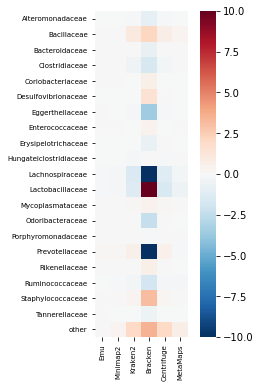

In [23]:
## cami2 Nanopore - family Level

cami2_theoretical_family = extract_abundance_theoretical(cami2_theoretical_path, 'family')
cami2_emu_family = extract_abundance_emu(cami2_emu_path,'family')
cami2_centrifuge_family = extract_abundance_centrifuge(cami2_centrifuge_path, 'family')
cami2_kraken_family = extract_abundance_kraken(cami2_kraken_path, 'family')
cami2_bracken_family = extract_abundance_bracken(cami2_bracken_family_path, 'family')
cami2_minimap_family = extract_abundance_primary(cami2_minimap_path, 'family', 'Minimap2')
cami2_metamaps_family = extract_abundance_metamaps(cami2_metamaps_path, 'family')

df_results_cami2_nanopore_family = cami2_theoretical_family
df_results_cami2_nanopore_family = pd.merge(df_results_cami2_nanopore_family, cami2_emu_family, how='outer', on=['family'])
df_results_cami2_nanopore_family = pd.merge(df_results_cami2_nanopore_family, cami2_minimap_family, how='outer', on=['family'])
df_results_cami2_nanopore_family = pd.merge(df_results_cami2_nanopore_family, cami2_kraken_family, how='outer', on=['family'])
df_results_cami2_nanopore_family = pd.merge(df_results_cami2_nanopore_family, cami2_bracken_family, how='outer', on=['family'])
df_results_cami2_nanopore_family = pd.merge(df_results_cami2_nanopore_family, cami2_centrifuge_family, how='outer', on=['family'])
df_results_cami2_nanopore_family = pd.merge(df_results_cami2_nanopore_family, cami2_metamaps_family, how='outer', on=['family'])
df_results_cami2_nanopore_family = df_results_cami2_nanopore_family.set_index("family")
df_results_cami2_nanopore_family.to_csv("./results_spreadsheets/cami2_family.tsv", sep='\t')

df_results_cami2_family_top20 = trim_df_keep_some(df_results_cami2_nanopore_family, top_num_df(df_results_cami2_nanopore_family))
cami2_family_diff = absolute_diff_heatmap(df_results_cami2_family_top20, "cami2_family")

print_L1_L2(df_results_cami2_nanopore_family, 'theoretical')
print_precision_recall(df_results_cami2_nanopore_family, 'theoretical')

## which Cami2 family does Emu miss?
thresh = 10/4310093*100
df_results_cami2_nanopore = cami2_theoretical_family
df_results_cami2_nanopore = pd.merge(df_results_cami2_nanopore, cami2_emu_family, how='left', on=['family'])
df_results_cami2_emu_missing = df_results_cami2_nanopore[df_results_cami2_nanopore['Emu'].isnull()]
df_results_cami2_emu_missing = df_results_cami2_emu_missing[df_results_cami2_emu_missing['theoretical']>thresh]
df_results_cami2_emu_missing

print("Percent Unclassified:")
get_unclassified_percent_emu(cami2_emu_path, 3949620, 'family')
get_unclassified_percent_minimap(cami2_minimap_path, 'family')
get_unclassified_percent_kreport(cami2_kraken_path, 'family')
get_unclassified_percent_bracken(cami2_bracken_family_path)



L1:
Emu           0.007768
Minimap2      0.024388
Kraken2       0.130457
Bracken       1.115202
Centrifuge    0.104835
MetaMaps      0.052383

L2:
Emu           0.001800
Minimap2      0.004008
Kraken2       0.021910
Bracken       0.372505
Centrifuge    0.018586
MetaMaps      0.012977



true_positives  false_positives  precision    recall   f_score
theoretical             180                0   1.000000  1.000000  1.000000
Emu                     171               69   0.712500  0.950000  0.814286
Minimap2                179             1482   0.107766  0.994444  0.194460
Kraken2                 176             2134   0.076190  0.977778  0.141365
Bracken                 105              542   0.162287  0.583333  0.253930
Centrifuge              180             2296   0.072698  1.000000  0.135542
MetaMaps                177             1366   0.114712  0.983333  0.205456



Percent Unclassified:
Emu: 9.38295783005822%
Minimap2: 9.394994493158269%
Kraken2: 17.65627795038297%
Bracken: 66.090778087619%


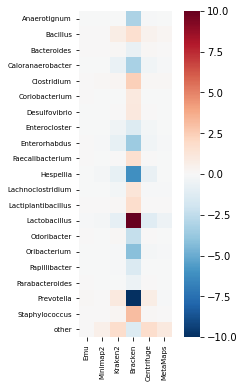

In [24]:
## cami2 Nanopore - genus Level

cami2_theoretical_genus = extract_abundance_theoretical(cami2_theoretical_path, 'genus')
cami2_emu_genus = extract_abundance_emu(cami2_emu_path,'genus')
cami2_centrifuge_genus = extract_abundance_centrifuge(cami2_centrifuge_path, 'genus')
cami2_kraken_genus = extract_abundance_kraken(cami2_kraken_path, 'genus')
cami2_bracken_genus = extract_abundance_bracken(cami2_bracken_genus_path, 'genus')
cami2_minimap_genus = extract_abundance_primary(cami2_minimap_path, 'genus', 'Minimap2')
cami2_metamaps_genus = extract_abundance_metamaps(cami2_metamaps_path, 'genus')

df_results_cami2_nanopore_genus = cami2_theoretical_genus
df_results_cami2_nanopore_genus = pd.merge(df_results_cami2_nanopore_genus, cami2_emu_genus, how='outer', on=['genus'])
df_results_cami2_nanopore_genus = pd.merge(df_results_cami2_nanopore_genus, cami2_minimap_genus, how='outer', on=['genus'])
df_results_cami2_nanopore_genus = pd.merge(df_results_cami2_nanopore_genus, cami2_kraken_genus, how='outer', on=['genus'])
df_results_cami2_nanopore_genus = pd.merge(df_results_cami2_nanopore_genus, cami2_bracken_genus, how='outer', on=['genus'])
df_results_cami2_nanopore_genus = pd.merge(df_results_cami2_nanopore_genus, cami2_centrifuge_genus, how='outer', on=['genus'])
df_results_cami2_nanopore_genus = pd.merge(df_results_cami2_nanopore_genus, cami2_metamaps_genus, how='outer', on=['genus'])
df_results_cami2_nanopore_genus = df_results_cami2_nanopore_genus.set_index("genus")
df_results_cami2_nanopore_genus.to_csv("./results_spreadsheets/cami2_genus.tsv", sep='\t')

df_results_cami2_genus_top20 = trim_df_keep_some(df_results_cami2_nanopore_genus, top_num_df(df_results_cami2_nanopore_genus))
cami2_genus_diff = absolute_diff_heatmap(df_results_cami2_genus_top20, "cami2_genus")

print_L1_L2(df_results_cami2_nanopore_genus, 'theoretical')
print_precision_recall(df_results_cami2_nanopore_genus, 'theoretical')

## which Cami2 genus does Emu miss?
thresh = 10/4310093*100
df_results_cami2_nanopore = cami2_theoretical_genus
df_results_cami2_nanopore = pd.merge(df_results_cami2_nanopore, cami2_emu_genus, how='left', on=['genus'])
df_results_cami2_emu_missing = df_results_cami2_nanopore[df_results_cami2_nanopore['Emu'].isnull()]
df_results_cami2_emu_missing = df_results_cami2_emu_missing[df_results_cami2_emu_missing['theoretical']>thresh]
df_results_cami2_emu_missing

print("Percent Unclassified:")
get_unclassified_percent_emu(cami2_emu_path, 3949620, 'genus')
get_unclassified_percent_minimap(cami2_minimap_path, 'genus')
get_unclassified_percent_kreport(cami2_kraken_path, 'genus')
get_unclassified_percent_bracken(cami2_bracken_genus_path)



L1:
Emu           0.025270
Minimap2      0.125128
Kraken2       0.425421
Bracken       1.450262
Centrifuge    0.238017
MetaMaps      0.114128

L2:
Emu           0.005081
Minimap2      0.019286
Kraken2       0.118024
Bracken       0.247403
Centrifuge    0.048213
MetaMaps      0.013411



true_positives  false_positives  precision    recall   f_score
theoretical             345                0   1.000000  1.000000  1.000000
Emu                     330              250   0.568966  0.956522  0.713514
Minimap2                343             4665   0.068490  0.994203  0.128152
Kraken2                 338             5879   0.054367  0.979710  0.103017
Bracken                 162             1175   0.121167  0.469565  0.192628
Centrifuge              343             6780   0.048154  0.994203  0.091859
MetaMaps                339             3271   0.093906  0.982609  0.171429



0.00023201355515994668 THRESHOLD



true_positives  false_positives  precision    recall   f_score
theoretical             333                0   1.000000  1.000000  1.000000
Emu                     329              251   0.567241  0.987988  0.720701
Minimap2                330              895   0.269388  0.990991  0.423620
Kraken2                 321             2832   0.101808  0.963964  0.184165
Bracken                 159             1178   0.118923  0.477477  0.190419
Centrifuge              327             3109   0.095169  0.981982  0.173521
MetaMaps                326             1223   0.210458  0.978979  0.346440



L1:
Emu           0.025262
Minimap2      0.122912
Kraken2       0.422853
Bracken       1.450258
Centrifuge    0.234977
MetaMaps      0.112170

L2:
Emu           0.005081
Minimap2      0.019286
Kraken2       0.118024
Bracken       0.247403
Centrifuge    0.048213
MetaMaps      0.013411

Percent Unclassified:
Emu: 8.363462226918529%
Minimap2: 8.365225529936362%
Kraken2: 34.34025669515716%
Bracken: 66.26729400038468%


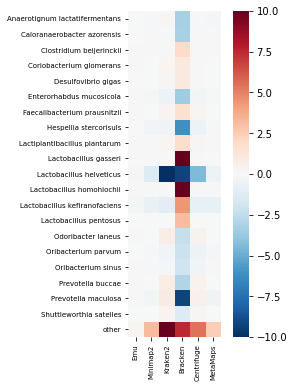

In [25]:
## cami2 Nanopore - species Level

cami2_theoretical_species = extract_abundance_theoretical(cami2_theoretical_path, 'species')
cami2_emu_species = extract_abundance_emu(cami2_emu_path,'species')
cami2_centrifuge_species = extract_abundance_centrifuge(cami2_centrifuge_path, 'species')
cami2_kraken_species = extract_abundance_kraken(cami2_kraken_path, 'species')
cami2_bracken_species = extract_abundance_bracken(cami2_bracken_species_path, 'species')
cami2_minimap_species = extract_abundance_primary(cami2_minimap_path, 'species', 'Minimap2')
cami2_metamaps_species = extract_abundance_metamaps(cami2_metamaps_path, 'species')

df_results_cami2_nanopore_species = cami2_theoretical_species
df_results_cami2_nanopore_species = pd.merge(df_results_cami2_nanopore_species, cami2_emu_species, how='outer', on=['species'])
df_results_cami2_nanopore_species = pd.merge(df_results_cami2_nanopore_species, cami2_minimap_species, how='outer', on=['species'])
df_results_cami2_nanopore_species = pd.merge(df_results_cami2_nanopore_species, cami2_kraken_species, how='outer', on=['species'])
df_results_cami2_nanopore_species = pd.merge(df_results_cami2_nanopore_species, cami2_bracken_species, how='outer', on=['species'])
df_results_cami2_nanopore_species = pd.merge(df_results_cami2_nanopore_species, cami2_centrifuge_species, how='outer', on=['species'])
df_results_cami2_nanopore_species = pd.merge(df_results_cami2_nanopore_species, cami2_metamaps_species, how='outer', on=['species'])
df_results_cami2_nanopore_species = df_results_cami2_nanopore_species.set_index("species")
df_results_cami2_nanopore_species.to_csv("./results_spreadsheets/cami2_species.tsv", sep='\t')

df_results_cami2_species_top20 = trim_df_keep_some(df_results_cami2_nanopore_species, top_num_df(df_results_cami2_nanopore_species))
cami2_species_diff = absolute_diff_heatmap(df_results_cami2_species_top20, "cami2_species")

print_L1_L2(df_results_cami2_nanopore_species, 'theoretical')
print_precision_recall(df_results_cami2_nanopore_species, 'theoretical')

thresh = 10/4310093*100
print(f"{thresh} THRESHOLD\n")
df_results_cami2_nanopore_species_copy = df_results_cami2_nanopore_species.copy()
df_results_cami2_nanopore_species_copy[df_results_cami2_nanopore_species_copy<=thresh]=0
#df_results_cami2_nanopore_species_copy['theoretical'] = df_results_cami2_nanopore_species['theoretical']
print_precision_recall(df_results_cami2_nanopore_species_copy, 'theoretical')
print_L1_L2(df_results_cami2_nanopore_species_copy, 'theoretical')


## which Cami2 species does Emu miss?
df_results_cami2_nanopore = cami2_theoretical_species
df_results_cami2_nanopore = pd.merge(df_results_cami2_nanopore, cami2_emu_species, how='left', on=['species'])
df_results_cami2_emu_missing = df_results_cami2_nanopore[df_results_cami2_nanopore['Emu'].isnull()]
df_results_cami2_emu_missing
#df_results_cami2_emu_missing[df_results_cami2_emu_missing['theoretical']>thresh]

print("Percent Unclassified:")
get_unclassified_percent_emu(cami2_emu_path, 3949620, 'species')
get_unclassified_percent_minimap(cami2_minimap_path, 'species')
get_unclassified_percent_kreport(cami2_kraken_path, 'species')
get_unclassified_percent_bracken(cami2_bracken_species_path)

